# BERT Analysis

Approaching using BERT to analyze the overview column plan:
* Problem Understanding
  * Extract themes, genres, or patterns that correlate with popularity
  * BERT can reveal the underlying patterns by identifying contextual keywords and themes
* Using BERT for Key Information Extraction
  * BERT is a pre-trained model that reads text in both directions (both directions means that it reads starting from the left and the right side)
  * This is good for understanding word context better
  * Encoder vs. Decoder
    * Encoder: Extracts contextual information (good for classification, clustering)
      * Goal is to assign labels (genre, sentiment) based on the content OR Goal is to group similar texts together based on their meaning or themes
      * BERT understands word meanings more since it reads both left and right contexts
    * Decoder: Generates sequences (like summaries or paraphrasing)
  * Encoder would be best since we can classify the theme of the show as "romance," "heist," etc.
  * Decoder might be used if we need to summarize the overview or generate a more compact feature from it

# Feature Extractions via Embeddings
* Convert each overview into BERT embeddings, which is our vector representations
* Use a pre-trained BERT model form Hugging Face (bert-base-uncased) to generate enbeddings
  * BERT-base is the original configuration of the BERT model
  * Using uncased model since the capitalization does not impact the meaning
  * Will test the results of the BERT model on cleaned and uncleaned text data
    * Read that using over cleaned data into the BERT model can negatively affect its performance
  * Can use cosine similarity to show the similarity between overviews (clustering shows with similar themes)

In [59]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TMDB_filename = os.path.join(os.getcwd(), "raw_TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [60]:
# import transformers library, which is a popular open-source library from HUgging Face
from transformers import BertTokenizer, BertModel
# import PyTorch to develop and train deep learning models
import torch
from tqdm import tqdm  # for progress bar

# loading the pre-trained BERT model and tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# tokenize and create tensor input
def get_embedding(text): 
  if pd.isnull(text):
    return torch.zeros(model.config.hidden_size).tolist()
  '''
  padding is set to true so that all input sequences have the same length
  truncation is set to true so that it truncates longer sequences that are longer
  than the models maximum input length so the text does not exceed the models capacity
  'return_tensor="pt"' means the output should be returned as a PyTorch tensor since the 
  model requires input in tensor format to perform computations
  '''
  tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
  '''
  torch.no_grad() disables gradient tracking to reduce memory consumption for computations that do not require gradients
  model(**tokens) passes the tokenized input to the pre-trained model (BERT)
  '''
  with torch.no_grad(): # generate embeddings 
    outputs = model(**tokens)
  '''
  outputs.last_hidden_state retrieves the hidden states from the last layer of the model for all tokens in the input sequence.
  Each token has an associated embedding vector.
  mean(dim=1) calculates the mean of the embeddings along the token dimension, which produces a single embedding vector for the entire input text, which
  can be used for various downstream tasks like classification, clustering, etc.
  '''
  return outputs.last_hidden_state.mean(dim=1).squeeze().tolist() # average pooling of embedings

In [61]:
# function to process the DataFrame with progress tracking
def process_with_progress(series):
  embeddings = []
  for text in tqdm(series, desc="Processing Embeddings"):
    embeddings.append(get_embedding(text))
  return embeddings

* Use the get_embedding function on the text data from the overview column

In [62]:
# process the overview column and assign embeddings to a new column
df['bert_cleaned_overview'] = process_with_progress(df['overview'])

print("Processing complete!")

Processing Embeddings:   0%|          | 0/168639 [00:00<?, ?it/s]

Processing Embeddings: 100%|██████████| 168639/168639 [1:28:00<00:00, 31.94it/s]  


Processing complete!


# Clustering/Classification
* After converting the overviews to embeddings:
  * Use clustering algorithms (K-Means) to find shows with similar themes
  * Classification model to predict genre based on overview content
  * If we noticed that certain clustered shows share a theme like "heist" we can make this a new feature in our dataset

In [63]:
# preprocess by ensuring the embeddings are in a suitable format (numpy array) and potentially normalize them
embeddings_array = np.vstack(df['bert_cleaned_overview'].to_numpy())

In [67]:
# use MiniBatchKMeans since it is a memory-efficient and faster version of KMeans that avoids some threading issues so we can do the clustering
from sklearn.cluster import MiniBatchKMeans

num_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100)
df['cluster'] = kmeans.fit_predict(embeddings_array)

* Since we are using BERT-base embeddings, each embedding vector has 768 dimensions
* This means for every text in our dataset, there is a 768-dimensional vector

In [70]:
# inspect the shape to see the dimension of the data
print(f"Shape of embeddings array: {embeddings_array.shape}")

Shape of embeddings array: (168639, 768)


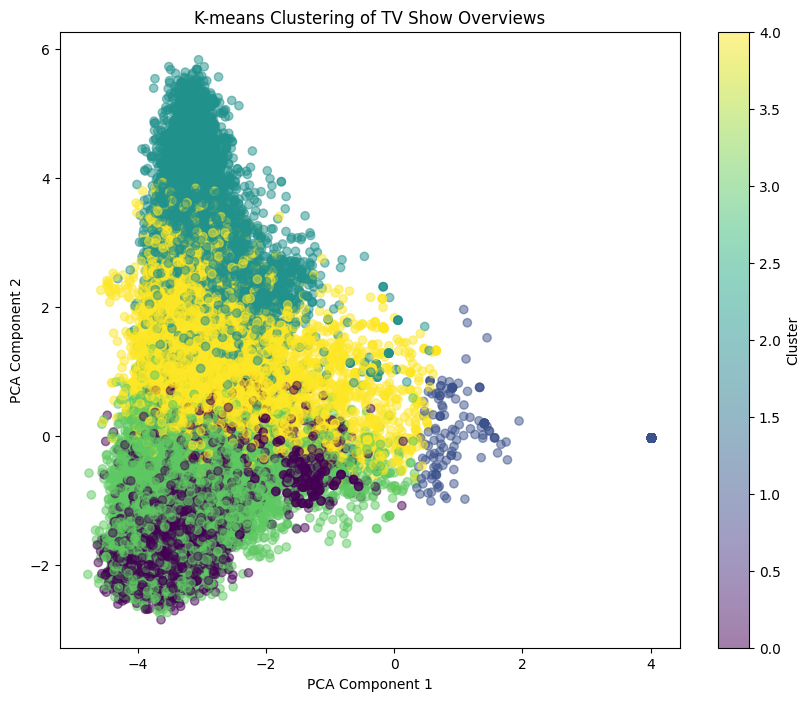

In [68]:
# using PCA to reduce dimensionality since the data is high-dimensional when visualizing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2) # reduce dimensions to 2 for visualization
reduced_embeddings = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of TV Show Overviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### K-means clustering results for TV show overviews reduced to two dimensions using PCA
* Axes (PCA Component 1 and 2)
  * The first two principle components resulting from PCA (PCA is used to reduce the dimensionality of the data)
  * Since the BERT embedings were high-dimensional, PCA was applied to project them in a 2D space
* Clusters
  * Each point represent a TV shows overview text that was converted into a BERT embedding
  * We specified 5 clusters, so the data points are grouped based on the similarity
  * The similarity between tv shows is based on the semantic meaning captured by the BERT embeddings
  * Shows that are closer have more similar content in their overviews, while shows in different clusters have distinct textual differences
  * The color bar on the right hand side indicates the cluster label assigned by the K-means algorithm
    * The numbers 0, 1, 2, 3, 4 correspond to different clusters
* Insights
  * The overlap in the clusters means that some TV shows share themes across multiple groups
  * The isolated blue cluster on the right could suggest a group of TV shows with overviews that are semantically distinct from other shows

### Next Steps
* Analyze the content of the clusters by looking at the shows in each group
* Experiment with more clusters

View Sample Data for Each Cluster

In [71]:
for cluster_id in range(num_clusters):
  print(f"\nCluster {cluster_id}:")
  display(df[df['cluster'] == cluster_id][['name', 'overview', 'genres']].head(10))


Cluster 0:


,name,overview,genres
11,The Big Bang Theory,Physicists Leonard and Sheldon find their nerd...,Comedy
12,Loki,After stealing the Tesseract during the events...,"Drama, Sci-Fi & Fantasy"
19,Elite,When three working class kids enroll in the mo...,"Crime, Mystery, Drama"
21,Rick and Morty,Rick is a mentally-unbalanced but scientifical...,"Animation, Comedy, Sci-Fi & Fantasy, Action & ..."
24,Naruto Shippūden,After 2 and a half years Naruto finally return...,"Animation, Action & Adventure, Sci-Fi & Fantasy"
29,Sex Education,Inexperienced Otis channels his sex therapist ...,"Comedy, Drama"
33,Cobra Kai,This Karate Kid sequel series picks up 30 year...,"Action & Adventure, Drama, Comedy"
34,Demon Slayer: Kimetsu no Yaiba,"It is the Taisho Period in Japan. Tanjiro, a k...","Animation, Action & Adventure, Sci-Fi & Fantasy"
39,Naruto,"In another world, ninja are the ultimate power...","Animation, Action & Adventure, Sci-Fi & Fantasy"
46,Dragon Ball Super,"With Majin Boo defeated half-a-year prior, pea...","Animation, Action & Adventure, Sci-Fi & Fantasy"



Cluster 1:


,name,overview,genres
245,40 y 20,NaN,Comedy
391,Ecomoda,NaN,"Comedy, Drama"
441,Rosario Tijeras,NaN,"Action & Adventure, Crime, Drama"
489,Rubi,NaN,Soap
524,A Family of Ten,NaN,Comedy
657,El Chapulín Colorado,NaN,"Comedy, Family, Crime, Sci-Fi & Fantasy, Mystery"
719,María de Todos los Ángeles,NaN,"Drama, Comedy, Family"
832,Amar a Muerte,NaN,"Drama, Soap"
901,La Familia del Barrio,NaN,Comedy
943,A Terra Prometida,NaN,Soap



Cluster 2:


,name,overview,genres
93,"Yo soy Betty, la fea","Yo soy Betty, la fea is a telenovela filmed in...","Soap, Comedy, Drama"
321,What Life Took From Me,"""What Life Took From Me"" is a Mexican telenove...",Drama
368,Without Breasts There Is No Paradise,Sin Senos no hay Paraíso is a RTI Colombia–Tel...,"Action & Adventure, Drama"
388,The Tom and Jerry Show,The New Tom & Jerry Show is an animated televi...,"Animation, Comedy, Kids, Family"
407,Zoey 101,Zoey 101 is an American television series whic...,"Drama, Comedy"
500,Little House on the Prairie,Little House on the Prairie is an American Wes...,"Western, Drama, Family"
591,Justice League Unlimited,Justice League Unlimited is an American animat...,"Animation, Action & Adventure"
630,The Little Mermaid,Disney's The Little Mermaid is an American ani...,"Family, Animation, Kids"
637,True Love,Amores verdaderos is a 2012 Mexican telenovela...,NaN
649,Doña Bárbara,Doña Bárbara is a Spanish-language telenovela ...,"Drama, Comedy, Soap"



Cluster 3:


,name,overview,genres
0,Game of Thrones,Seven noble families fight for control of the ...,"Sci-Fi & Fantasy, Drama, Action & Adventure"
1,Money Heist,"To carry out the biggest heist in history, a m...","Crime, Drama"
2,Stranger Things,"When a young boy vanishes, a small town uncove...","Drama, Sci-Fi & Fantasy, Mystery"
3,The Walking Dead,Sheriff's deputy Rick Grimes awakens from a co...,"Action & Adventure, Drama, Sci-Fi & Fantasy"
4,Lucifer,"Bored and unhappy as the Lord of Hell, Lucifer...","Crime, Sci-Fi & Fantasy"
5,Riverdale,"Set in the present, the series offers a bold, ...","Crime, Drama, Mystery"
6,Squid Game,Hundreds of cash-strapped players accept a str...,"Action & Adventure, Mystery, Drama"
7,Breaking Bad,"When Walter White, a New Mexico chemistry teac...","Drama, Crime"
8,The Good Doctor,"Shaun Murphy, a young surgeon with autism and ...",Drama
9,WandaVision,Wanda Maximoff and Vision—two super-powered be...,"Sci-Fi & Fantasy, Mystery, Drama"



Cluster 4:


,name,overview,genres
15,The Simpsons,"Set in Springfield, the average American town,...","Family, Animation, Comedy"
157,BoJack Horseman,Meet the most beloved sitcom horse of the 90s ...,"Animation, Comedy, Drama"
438,Shadow Hunter,"A documentary series about the paranormal, hos...","Sci-Fi & Fantasy, Drama"
456,The Grim Adventures of Billy and Mandy,"The exploits of the Grim Reaper, who has been ...","Animation, Comedy, Family"
461,American Crime Story,An anthology series centered around some of hi...,"Crime, Drama"
473,Atrévete a soñar,"Danna Paola stars as Patito, Eleazar Gómez as ...",Drama
544,American Horror Stories,An anthology series of stand alone episodes de...,"Drama, Mystery, Sci-Fi & Fantasy"
643,PAW Patrol,PAW Patrol is a CG action-adventure for old ch...,"Animation, Kids"
656,Top Gear,This fast-paced and stunt-filled motor show te...,"Talk, Documentary, Action & Adventure, Comedy"
673,Animaniacs,The two Warner Brothers Yakko and Wakko and th...,"Animation, Kids, Comedy, Family"


Get Genre Distributions per Cluster

In [73]:
for cluster_id in range(num_clusters):
  print(f"\nCluster {cluster_id} Genre Distribution:")
  genre_counts = df[df['cluster'] == cluster_id]['genres'].value_counts()
  print(genre_counts.head(10))


Cluster 0 Genre Distribution:
genres
Drama                5154
Comedy               1608
Animation            1214
Comedy, Drama         858
Drama, Comedy         747
Animation, Comedy     595
Kids                  387
Drama, Family         365
Drama, Mystery        337
Crime, Drama          266
Name: count, dtype: int64

Cluster 1 Genre Distribution:
genres
Documentary        8130
Drama              5685
Comedy             3617
Reality            3288
Talk               1153
Animation          1096
Family              566
Crime               545
Kids                492
Animation, Kids     472
Name: count, dtype: int64

Cluster 2 Genre Distribution:
genres
Drama                        1643
Comedy                       1187
Animation                     317
Drama, Comedy                 203
Documentary                   198
Reality                       129
Animation, Comedy             112
Action & Adventure            105
Action & Adventure, Drama      99
Western                     

Plot Genre Distribution Per Cluster For Visual Comparison

In [78]:
# flatten genres into individual entries
df_exploded = df.explode('genres')  # if 'genres' is a list

plt.figure(figsize=(15, 5))
sns.countplot(data=df_exploded, x='genres', hue='cluster')
plt.xticks(rotation=90)
plt.title("Genre Distribution by Cluster")
plt.show()

Identify Themes or Topics in Overviews

In [76]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# get the list of stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/safiaboutaleb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
from collections import Counter
import re

# function to get the top words from overviews in a given cluster
def get_top_words(cluster_id, num_words=20):
  overviews = df[df['cluster'] == cluster_id]['overview'].fillna('')
  
  # combine all overviews into a single string, and split into words
  all_words = ' '.join(overviews).lower()
  
  # remove punctuation and split into words
  all_words = re.findall(r'\b\w+\b', all_words)
  
  # filter out stop words
  filtered_words = [word for word in all_words if word not in stop_words]
  
  # count word frequencies
  word_counts = Counter(filtered_words)
  
  return word_counts.most_common(num_words)

# print the top words for each cluster
for cluster_id in range(num_clusters):
  print(f"\nTop words in Cluster {cluster_id}:")
  print(get_top_words(cluster_id))


Top words in Cluster 0:
[('life', 6471), ('love', 6235), ('one', 5629), ('family', 4960), ('story', 4230), ('school', 4191), ('young', 3872), ('two', 3812), ('new', 3363), ('man', 3337), ('girl', 3327), ('time', 3184), ('years', 3116), ('day', 3109), ('world', 3008), ('father', 2950), ('series', 2635), ('also', 2584), ('mother', 2567), ('old', 2532)]

Top words in Cluster 1:
[('edit', 14), ('translation', 13), ('available', 7), ('overview', 7), ('commented', 6), ('miniseries', 5), ('series', 5), ('catalan', 3), ('reality', 3), ('details', 3), ('documentary', 3), ('drama', 2), ('unavailable', 2), ('noon', 2), ('elnaswa', 2), ('description', 2), ('family', 2), ('show', 2), ('indian', 2), ('weddings', 2)]

Top words in Cluster 2:
[('series', 12572), ('television', 8862), ('aired', 5819), ('show', 4706), ('produced', 3354), ('american', 3105), ('episodes', 2346), ('drama', 2265), ('tv', 2248), ('network', 2099), ('first', 1933), ('broadcast', 1865), ('september', 1502), ('based', 1489), (

Creating a Word Cloud for Each Cluster

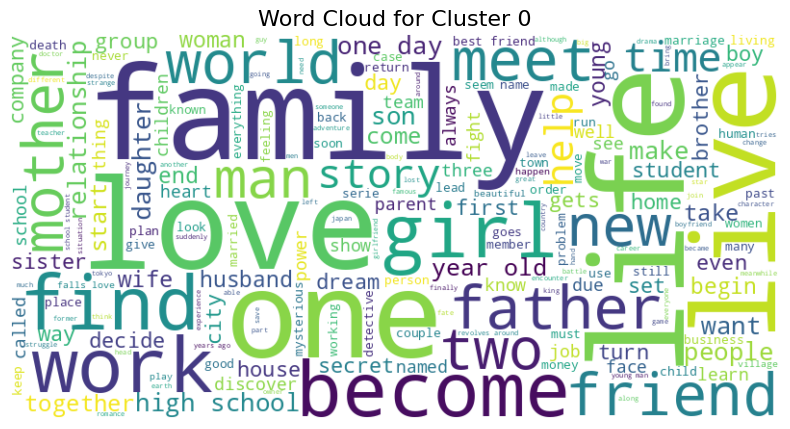

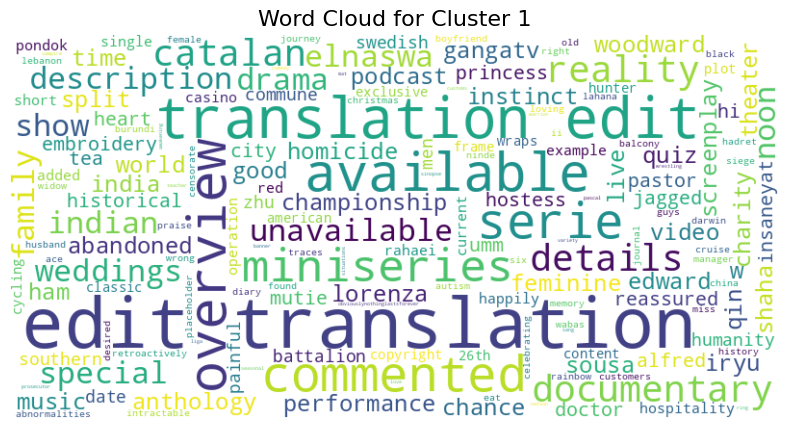

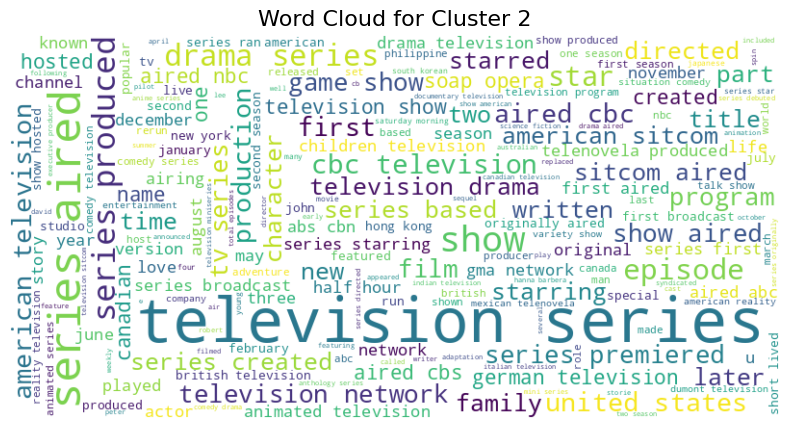

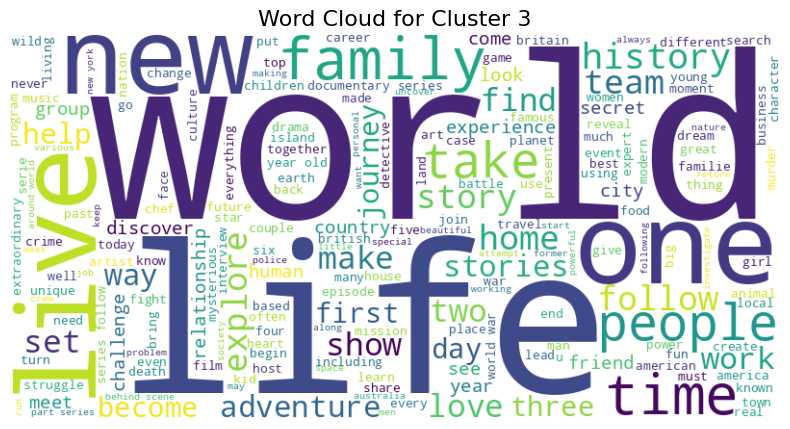

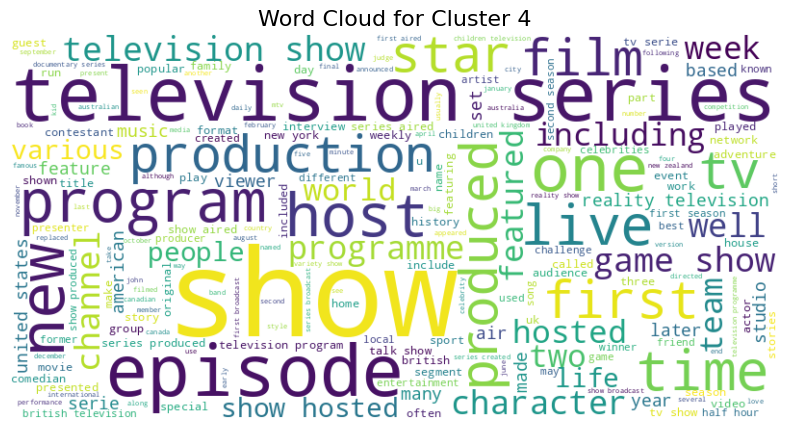

In [79]:
from wordcloud import WordCloud

def generate_word_cloud(cluster_id):
  overviews = df[df['cluster'] == cluster_id]['overview'].fillna('')
  all_words = ' '.join(overviews).lower()
  words = re.findall(r'\b\w+\b', all_words)
  filtered_words = [word for word in words if word not in stop_words]
  text = ' '.join(filtered_words)

  # create the word cloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Cluster {cluster_id}', fontsize=16)
  plt.show()

# generate word clouds for all clusters
for cluster_id in range(num_clusters):
  generate_word_cloud(cluster_id)
